In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

# Define device
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Define data transformations
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming standard normalization, update based on dataset stats if available
train_transforms = tt.Compose([
    tt.Resize((128, 128)),  # Resize to 128x128, can be adjusted based on model
    tt.RandomCrop(128, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats)
])
val_transforms = tt.Compose([
    tt.Resize((128, 128)),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

# Load the Flowers102 dataset
train_ds = Flowers102(root='./data', split='train', transform=train_transforms, download=True)
val_ds = Flowers102(root='./data', split='val', transform=val_transforms, download=True)
test_ds = Flowers102(root='./data', split='test', transform=val_transforms, download=True)

# Create DataLoaders
batch_size = 32  # Adjust based on your GPU memory
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)

# DeviceDataLoader for moving data to device
def swapDevice(data, device):
    if isinstance(data, (list,tuple)):
        return [swapDevice(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield swapDevice(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


# Define the model (ResNet9 or any other suitable architecture)
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x









class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], last_lr: {result['lrs'][-1]:.5f}, train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")





# Accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))



def conv(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv(in_channels, 64)
        self.conv2 = conv(64, 128, pool=True)
        self.res1 = nn.Sequential(conv(128, 128), conv(128, 128))

        self.conv3 = conv(128, 256, pool=True)
        self.conv4 = conv(256, 512, pool=True)
        self.res2 = nn.Sequential(conv(512, 512), conv(512, 512))

        # Corrected classifier to match flatten size
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Adaptive pooling to get a fixed size of 1x1
            nn.Flatten(),
            nn.Linear(512, num_classes)  # Only 512 input features now due to AdaptiveAvgPool2d
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        # print("Shape before flatten:", out.shape)  # Debugging shape, should now be [batch_size, 512, 1, 1]
        out = self.classifier(out)
        return out

# Initialize the model again with the updated ResNet9
model = swapDevice(ResNet9(3, 102), device)





# Training and evaluation functions remain the same

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def foc(number_of_epochs, lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Initialize optimizer and scheduler
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=number_of_epochs, steps_per_epoch=len(train_loader))

    for epoch in range(number_of_epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & step scheduler
            lrs.append(get_lr(optimizer))
            scheduler.step()

        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()  # Compute mean training loss
        result['lrs'] = lrs

        # Log epoch end
        model.epoch_end(epoch, result)
        history.append(result)

    return history


# Evaluate the model before training
h = [evaluate(model, val_dl)]

# Define training parameters
opt_func = torch.optim.Adam
weight_decay = 1e-4
n_o_epochs = 300  # Adjust based on your training requirements
m_lr = 0.01
grad_clip = 0.1





# Evaluate the model before training (optional)
initial_result = evaluate(model, val_dl)
print(f"Initial evaluation - val_loss: {initial_result['val_loss']:.4f}, val_acc: {initial_result['val_acc']:.4f}")

# Training loop
h = foc(n_o_epochs, m_lr, model, train_dl, val_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

# Final evaluation on the test dataset
test_result = evaluate(model, test_dl)
print(f"Test evaluation - val_loss: {test_result['val_loss']:.4f}, val_acc: {test_result['val_acc']:.4f}")


100%|██████████| 344862509/344862509 [00:16<00:00, 20342007.92it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 722064.68it/s]


100%|██████████| 14989/14989 [00:00<00:00, 17551206.77it/s]


Initial evaluation - val_loss: 4.6256, val_acc: 0.0124
Epoch [0], last_lr: 0.00040, train_loss: 4.4018, val_loss: 3.9891, val_acc: 0.0909
Epoch [1], last_lr: 0.00041, train_loss: 3.6638, val_loss: 3.7170, val_acc: 0.1440
Epoch [2], last_lr: 0.00043, train_loss: 3.3126, val_loss: 3.5610, val_acc: 0.1751
Epoch [3], last_lr: 0.00045, train_loss: 3.0606, val_loss: 3.2208, val_acc: 0.2113
Epoch [4], last_lr: 0.00047, train_loss: 2.8912, val_loss: 3.1638, val_acc: 0.2368
Epoch [5], last_lr: 0.00050, train_loss: 2.7118, val_loss: 3.1982, val_acc: 0.2475
Epoch [6], last_lr: 0.00054, train_loss: 2.6080, val_loss: 2.9669, val_acc: 0.2841
Epoch [7], last_lr: 0.00058, train_loss: 2.4593, val_loss: 2.9652, val_acc: 0.2928
Epoch [8], last_lr: 0.00063, train_loss: 2.3411, val_loss: 3.1706, val_acc: 0.2395
Epoch [9], last_lr: 0.00069, train_loss: 2.2851, val_loss: 2.8624, val_acc: 0.3045
Epoch [10], last_lr: 0.00075, train_loss: 2.2013, val_loss: 3.0071, val_acc: 0.2730
Epoch [11], last_lr: 0.00081, t

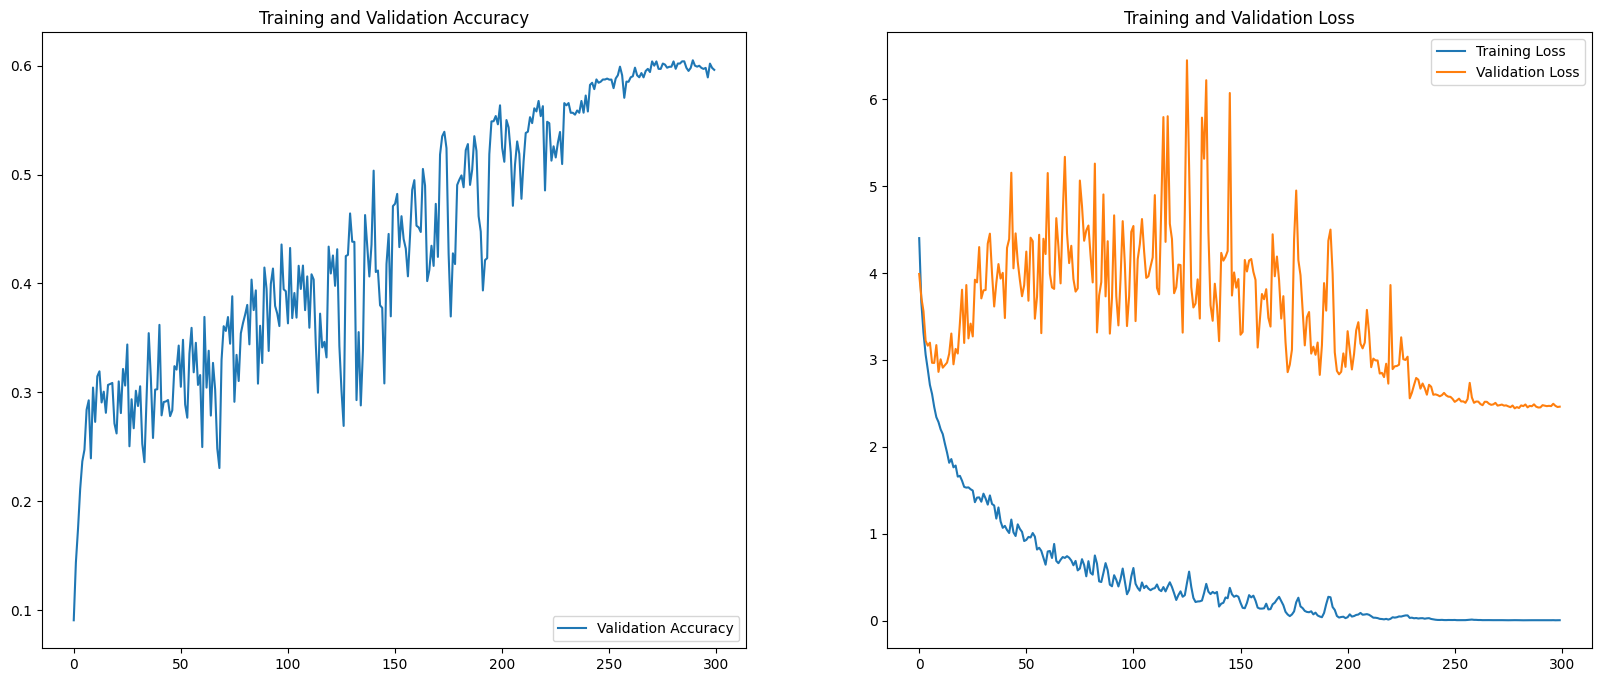

In [2]:
# Extracting the data from the history list
trainLoss = [x['train_loss'] for x in h]
valLoss = [x['val_loss'] for x in h]
valAcc = [x['val_acc'] for x in h]
epochs = range(len(h))  # Number of epochs

# Plotting the training and validation accuracy and loss
plt.figure(figsize=(20, 8))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, valAcc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, trainLoss, label='Training Loss')
plt.plot(epochs, valLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
